In [1]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
from nitime import algorithms as alg


C:\Anaconda3\lib\site-packages\pandas\__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)
C:\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
C:\Anaconda3\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
C:\Anaconda3\lib\site-packages\ipykernel\pylab\

In [2]:
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()

['64chlocs.elp', 'label_extraction.npy', 'label_extraction.pkl', 'pipe line 10', 'pipe line 10.csv', 's5d2_final.edf', 's5d2_final_annotations.txt', 's6n2_final.edf', 's6n2_final_annotations.txt', 'Sleep Stage Scoring Criteria.docx', 'suj10_d1final.edf', 'suj10_d1final_annotations.txt', 'suj10_d2final.edf', 'suj10_d2final_annotations.txt', 'suj13_l2nap_day2 edited.edf', 'suj13_l2nap_day2 edited1.edf', 'suj13_l2nap_day2 edited1_annotations.txt', 'suj13_l2nap_day2 edited_annotations.txt', 'suj13_l2nap_day2 edited_C3.txt', 'suj13_l2nap_day2 edited_C4.txt', 'suj13_l2nap_day2 edited_F3.txt', 'suj13_l2nap_day2 edited_F4.txt', 'suj13_l2nap_day2 edited_O1.txt', 'suj13_l2nap_day2 edited_O2.txt', 'suj5_d1final.edf', 'suj5_d1final_annotations.txt', 'suj6_d1final.edf', 'suj6_d1final_annotations.txt', 'suj8_d1final.edf', 'suj8_d1final_annotations.txt', 'suj8_d2final.edf', 'suj8_d2final_annotations.txt', 'suj9_d1final.edf', 'suj9_d1final_annotations.txt', 'suj9_d2final.edf', 'suj9_d2final_annotation

In [3]:
file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=2)
# channel list for artifact(eyemovement or chewing) removal - ROC and/or LOC
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,None, 100)# low pass
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0])
labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
spindles=[]
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])

Extracting edf Parameters from suj10_d1final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 3601999  =      0.000 ...  3601.999 secs...
[done]
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 2 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    2, 7, 4, 4, 2
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 3 ICA components
Inverse transforming to PCA space
Reconstructing sensor space signals from 8 PCA components
Low-pass filtering at 5e+02 Hz
Low-pass filtering at 1e+02 Hz


In [4]:
ratio_index={}
muscle_index={}
sample_ind={}
for ii,names in enumerate(channelList):
    if names == 'ROC' or names == 'LOC':
        pass
    else:
        windowsize=5;ratio_index[names]=[];muscle_index[names]=[];sample_ind[names]=[]
        endPoint = 5;startPoint=endPoint-windowsize
        distance_to_end = raw.last_samp/1000 - endPoint
        while distance_to_end >0:
            start,stop = raw.time_as_index([startPoint,endPoint])
            segment, time = raw[ii,start:stop];
            filter_alpha = mne.filter.band_pass_filter(segment,1000,8,12);
            RMS_alpha = np.sqrt(sum(filter_alpha[0]**2)/len(filter_alpha))
            filter_spindle = mne.filter.band_pass_filter(segment,1000,11.5,16)
            RMS_spindle = np.sqrt(sum(filter_spindle[0]**2))/len(filter_spindle)
            filter_muscle = mne.filter.band_pass_filter(segment,1000,30,40)
            RMS_muscle = np.sqrt(sum(filter_muscle[0]**2)/len(filter_muscle))
            #print(RMS_alpha,RMS_spindle,RMS_muscle)
            point = [0,0]
            if RMS_alpha/RMS_spindle < 1.2:
                point[0] +=2
                ratio_index[names].append(2)
            else:
                point[0] -= 1
                ratio_index[names].append(-1)
            if RMS_muscle >5*10e-4:
                point[1] -=1
                muscle_index[names].append(-1)
            else:
                muscle_index[names].append(0)
            sample_ind[names].append(sum(point))
            
            
            endPoint += 1#determine step size, the smaller, the high sampling rate
            startPoint=endPoint-windowsize
            distance_to_end = raw.last_samp/1000 - endPoint    

C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 12.5Hz is only 18.0dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 16.5Hz is only 18.0dB.
  '%0.1fdB.' % (att_freq, att_db))
C:\Anaconda3\lib\site-packages\mne\filter.py:333: UserWarning: Attenuation at stop frequency 40.5Hz is only 17.9dB.
  '%0.1fdB.' % (att_freq, att_db))


In [ ]:
# add one more data point for backward search algorithm!!

In [5]:
general_result = pd.DataFrame(sample_ind)

In [8]:
mark_pairs={};indicator={};resolution = 1
channelList=['F3','F4','C3','C4','O1','O2']
for ii, names in enumerate(channelList):
    mark_pairs[names]=[];indicator[names]=[]
    for cells in range(len(general_result[names])):
        if cells == len(general_result[names]) -1:
            pass
        else:
            indicator[names].append(general_result[names][cells+1]-general_result[names][cells])
            
            if indicator[names][cells] == -3:
                endPoint = cells * resolution
                initial_position = cells;position_idx = cells
                try:
                    while indicator[names][initial_position] != 3:
                        position_idx -= 1 # backward search
                        initial_position = position_idx
                    startPoint = position_idx * resolution
                    
                    if endPoint - startPoint >= 1:
                        mark_pairs[names].append([startPoint, endPoint])
                        
                except:
                    pass
                

(-1, 7)

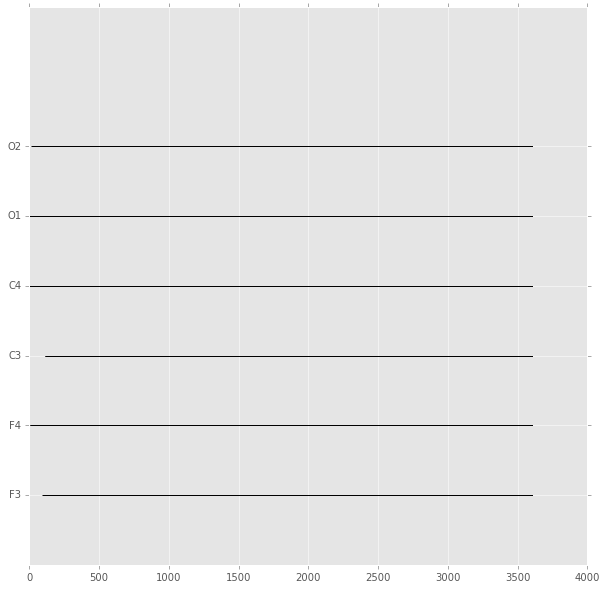

In [50]:
plt.figure(figsize=(10,10))
for ii, names in enumerate(channelList):
    for item in mark_pairs[names]:
        plt.hlines(ii,item[0],item[1])
        
plt.yticks(np.arange(6),channelList)
plt.ylim([-1,7])

In [51]:
print(mark_pairs)

{'C3': [[112, 3602], [114, 3602], [132, 3602], [176, 3602], [197, 3602], [202, 3602], [224, 3602], [235, 3602], [249, 3602], [259, 3602], [271, 3602], [273, 3602], [278, 3602], [291, 3602], [298, 3602], [316, 3602], [342, 3602], [363, 3602], [382, 3602], [396, 3602], [399, 3602], [410, 3602], [418, 3602], [421, 3602], [424, 3602], [431, 3602], [439, 3602], [471, 3602], [479, 3602], [483, 3602], [498, 3602], [500, 3602], [509, 3602], [511, 3602], [518, 3602], [522, 3602], [537, 3602], [539, 3602], [553, 3602], [557, 3602], [579, 3602], [586, 3602], [596, 3602], [603, 3602], [611, 3602], [619, 3602], [639, 3602], [646, 3602], [651, 3602], [661, 3602], [669, 3602], [691, 3602], [706, 3602], [728, 3602], [736, 3602], [746, 3602], [750, 3602], [755, 3602], [776, 3602], [803, 3602], [812, 3602], [820, 3602], [825, 3602], [835, 3602], [845, 3602], [863, 3602], [867, 3602], [879, 3602], [884, 3602], [893, 3602], [901, 3602], [911, 3602], [938, 3602], [947, 3602], [955, 3602], [959, 3602], [975

In [15]:
spindle_overlapping = {}
for ii, names in enumerate(channelList):
    spindle_overlapping[names]=[]
    for items in spindles:
        
        for rows in mark_pairs[names]:
            if (abs(rows[0]-items)<2) or (abs(rows[1]-items)<2):
                spindle_overlapping[names].append(1)
            else:
                spindle_overlapping[names].append(0)
            

In [25]:
for keys in spindle_overlapping.keys():
    print(sum(spindle_overlapping[keys]),len(spindles))

31 140
31 140
37 140
25 140
48 140
27 140


In [26]:
sleep_annotation=[]
searchLabel = re.compile('Markon: 2',re.IGNORECASE)
for rows in file.iterrows():
    currentEvent = rows[-1][-1]
    if searchLabel.search(currentEvent):
        sleep_annotation.append([rows[1][0],rows[1][0]+30])
        

In [41]:
overlapping_index

{'C3': array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,  15.431291]]),
 'C4': array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.  

In [27]:
# whether two intervals overlap
def getOverlap(a,b):
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))

In [30]:
overlapping_index={}
for ii,names in enumerate(channelList):
    for rows in mark_pairs[names]:
        over_lapping = [];overlapping_index[names]=[]
        for items in sleep_annotation:
            over_lapping.append(getOverlap(rows,items))
        overlapping_index[names].append(over_lapping)

In [35]:
overlappingIndex={}
for ii, names in enumerate(channelList):
    overlapping_index[names]=np.array(overlapping_index[names]);
    overlapping_index[names][overlapping_index[names] < 1.]=0
    overlappingIndex[names]=[]
    for idxes,lines in enumerate(overlapping_index[names]):
        if sum((lines == 0).astype(int)-1) !=0:
            overlappingIndex[names].append(idxes)

In [37]:
overlapping_index

{'C3': array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,  15.431291]]),
 'C4': array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.  